### Extract outcome variables from excel sheret

In [1]:
import pandas as pd
import json

In [5]:
# Load the CSV file
csv_file_path = "/Users/eveyhuang/Documents/NICO/gemini_code/data/2021SLU/SLU_teams_2021.xlsx"
df = pd.read_excel(csv_file_path)

# Process the data
teams_data = []
for index, row in df.iterrows():
    team_id = row['team_id']
    funded_status = 1 if row['funding_status'] == 'funded' else 0
    team_members = row['team_members'].split(', ')
    
    team_info = {
        "team_id": team_id,
        "funded_status": funded_status,
        "members": team_members
    }
    teams_data.append(team_info)

output_file_path = '/Users/eveyhuang/Documents/NICO/gemini_code/data/2021SLU/2021SLU_outcome.json'

# Save the teams_data to a JSON file
with open(output_file_path, 'w') as json_file:
    json.dump(teams_data, json_file, indent=4)

# Output the result
print(teams_data)

[{'team_id': 'SLU1', 'funded_status': 0, 'members': ['Smadar Naoz', 'Keith Hawkins', 'Daniel Huber']}, {'team_id': 'SLU2', 'funded_status': 0, 'members': ['Andrew Vanderburg', 'Paul Robertson']}, {'team_id': 'SLU3', 'funded_status': 0, 'members': ['Eliza Kempton', 'Mathieu Lapotre', 'Laura Schaefer']}, {'team_id': 'SLU4', 'funded_status': 0, 'members': ['Stephanie Olson', 'Meredith MacGregor', 'Nathaniel Gabor']}, {'team_id': 'SLU5', 'funded_status': 0, 'members': ['Tyler Robinson', 'Liming Li']}, {'team_id': 'SLU6', 'funded_status': 0, 'members': ['Gregory Fournier', 'Gongjie Li']}, {'team_id': 'SLU7', 'funded_status': 1, 'members': ['Stilianos Louca', 'Gregory Fournier']}, {'team_id': 'SLU8', 'funded_status': 0, 'members': ['Laura Barge', 'Andro Rios']}, {'team_id': 'SLU9', 'funded_status': 0, 'members': ['Leslie Rogers', 'Ke Zhang']}, {'team_id': 'SLU10', 'funded_status': 1, 'members': ['Laura Schaefer', 'Meredith MacGregor', 'Aaron Engelhart']}, {'team_id': 'SLU11', 'funded_status'

### merge data for each session in output into data folder

In [25]:
import re

def add_times(time1, time2):
    
    # Split the time strings into hours and minutes
    hours1, minutes1 = map(int, time1.split(':'))
    hours2, minutes2 = map(int, time2.split(':'))
    
    # Add the hours and minutes separately
    total_hours = hours1 + hours2
    total_minutes = minutes1 + minutes2
    
    # If total minutes are 60 or more, convert to hours
    if total_minutes >= 60:
        total_hours += total_minutes // 60
        total_minutes = total_minutes % 60
    
    #print(f"adding {time1} and {time2} result is {total_hours:02}:{total_minutes:02}")
    # Format the result as "HH:MM"
    return f"{total_hours:02}:{total_minutes:02}"

def normalize_name(full_string):
    """
    Extracts just the name from various formats of name strings.
    
    Args:
        full_string: String containing name and additional information
        
    Returns:
        String containing just the name
    
    """
    # Remove common titles
    full_string = re.sub(r'^(Dr\.?|Prof\.?|Professor|Mr\.?|Ms\.?|Mrs\.?)\s+', '', full_string, flags=re.IGNORECASE)
    
    # Remove everything after common separators
    for separator in [' (', '-', ',']:
        if separator in full_string:
            full_string = full_string.split(separator)[0]
    
    # Clean up any remaining whitespace
    name = full_string.strip()
    
    name = name.replace('.', '')
    # Handle cases where institution is connected with a hyphen without space
    parts = name.split('-')
    if len(parts) > 1:
        # Check if the part after hyphen contains "University" or similar institutional words
        if any(word in parts[-1].lower() for word in ['university', 'college', 'institute', 'school', 'u of']):
            name = parts[0].strip()
    
    return name

def split_name(name):
    """Split a name into first and last (handles middle names by joining all but last as first)."""
    parts = name.strip().split()
    if len(parts) == 1:
        return parts[0], ""
    return " ".join(parts[:-1]), parts[-1]
from difflib import SequenceMatcher

def find_matching_name(name, correct_names, last_name_threshold=0.9, first_name_threshold=0.3):
    """
    Fuzzy match names, requiring a strong match on last name and a looser match on first name.
    """
    name_first, name_last = split_name(name.lower())
    best_match = None
    best_score = 0

    for correct_name in correct_names:
        correct_first, correct_last = split_name(correct_name.lower())
        # Compare last names
        last_ratio = SequenceMatcher(None, name_last, correct_last).ratio()
        if last_ratio >= last_name_threshold:
            # Compare first names
            first_ratio = SequenceMatcher(None, name_first, correct_first).ratio()
            # Use average or weighted score for ranking
            score = (last_ratio + first_ratio) / 2
            if first_ratio >= first_name_threshold and score > best_score:
                best_score = score
                best_match = correct_name

    if best_match:
        return best_match, best_score
    return None, 0

# Example usage with more complex cases:
def find_and_correct_name(name, correct_names, threshold=0.8):
    """
    Wrapper function that provides more detailed output about name matching.
    
    Args:
        name: String containing the potentially misspelled name
        correct_names: List of correctly spelled names
        threshold: Float between 0 and 1, minimum similarity ratio to consider a match
        
    Returns:
        Dictionary containing matching information
    """
    name = normalize_name(name)
    match, ratio = find_matching_name(name, correct_names, threshold)
    result = {
        "input_name": name,
        "matched_name": match,
        "similarity": round(ratio, 3),
        "is_match": ratio >= threshold
    }
    
    return result

In [52]:
# CHANGE conf name here 
conf_name = '2021MND'

conference_dir = f'data/{conf_name}'

In [ ]:
import os
import json
from collections import defaultdict


with open(f'data/{conf_name}/{conf_name}_outcome.json') as f:
    teams_data = json.load(f)

team_data_names = set()

for team in teams_data:
    members = team['members']
    for name in members:
        team_data_names.add(name)


def normalize_keys(entry):
    normalized = {}
    for key, value in entry.items():
        normalized[key.replace(' ', '_')] = value
    return normalized

# merge data from output folders 
def merge_json_files(directory):
    merged_data = []
    all_speakers = []
    speaking_length = 0
    last_end_time = "00:00"
    unmatch_names = set()

    for root, _, files in os.walk(directory):
        for file in files:
            if file.startswith("all") and file.endswith(".json"):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    for entry in data:
                        entry = normalize_keys(entry)
                        
                        
                        match_name_result = find_and_correct_name(entry['speaker'], team_data_names)
                        if match_name_result['is_match']:
                            entry['speaker'] = match_name_result['matched_name']
                        else:
                            entry['speaker'] = match_name_result['input_name']
                            unmatch_names.add(entry['speaker'])
                        all_speakers.append(entry['speaker'])
                        speaking_length += int(entry['speaking_duration'])
                        entry['start_time'] = add_times(entry['start_time'], last_end_time)
                        entry['end_time'] = add_times(entry['end_time'], last_end_time)
                            
                        merged_data.append(entry)
                    try:    
                        last_end_time = max(entry['end_time'] for entry in data)
                    except ValueError:
                        print(f"Error processing file {file_path}: {data}")
                        continue
                    
    unique_speakers = set(all_speakers)   
    print(f"{directory}, unmatched names: {unmatch_names}")             
    return merged_data, list(unique_speakers), speaking_length

gemini_output_dir = f'outputs/{conf_name}'
output_dir = f'data/{conf_name}'

if not os.path.exists(output_dir):
     os.makedirs(output_dir)

for folder in os.listdir(gemini_output_dir):
     if folder.startswith("output"):
          folder_path = os.path.join(gemini_output_dir, folder)
          merged_data, all_speaker, speaking_length = merge_json_files(folder_path)
          
          result = {
                "all_speakers": all_speaker,
                "total_speaking_length": speaking_length,
                "all_data": merged_data,     
          }
          
          output_file_name = folder.replace("output_", "").strip()
          output_file_path = os.path.join(output_dir, f"{output_file_name}.json")
          
          with open(output_file_path, 'w') as f:
                json.dump(result, f, indent=4)


outputs/2021MZT/output_2021_09_30_MZT_S6, unmatched names: {'Matt Erdman', 'Sandra Laney', 'Troy Clavell Sutton', 'Pilar Fernandez'}
outputs/2021MZT/output_2021_09_30_MZT_S7, unmatched names: {'Andrew Feig', 'Daren Ginete', 'Guillaume Bastille', 'Salvador Almagro', 'Hannah Frank Tulane', 'Mike Wimberly', 'Bethany McGregor USDA ARS', 'Richard Wiener', 'adela', 'Rebecca Garabed', 'Gonzalo Vazquez', 'Linda Detwiler'}
outputs/2021MZT/output_2021_10_01_MZT_S3, unmatched names: {'Peter Dorhout', 'Andrew Feig', 'Becky Smith', 'Chuck Lewis', 'Daren Ginete', 'Pilar Fernandez', 'A Ali Yanik', 'Prashant Singh', 'Beth Lautner', 'Richard Wiener', 'Christine K Johnson', 'Peter Dornhout', 'Rebecca Garabed', 'Linda Detwiler'}
outputs/2021MZT/output_2021_10_01_MZT_S4, unmatched names: {'Andrew Feig', 'Chuck Lewis', 'Pilar Fernandez', 'Joyce Jose Penn State', 'Adela Detwiler', 'Angela Arenas TAMU', 'Rebecca Garabed'}
outputs/2021MZT/output_2021_10_01_MZT_S5, unmatched names: set()
outputs/2021MZT/output

In [ ]:
# Read outcome.json to get team information (match each person to their team and funding status)

outcome_file = os.path.join(conference_dir, f'{conf_name}_outcome.json')
with open(outcome_file, 'r') as f:
    outcome_data = json.load(f)

# Create a mapping of normalized full names to their team IDs
name_to_teams = defaultdict(list)  # Changed to defaultdict to store multiple teams per person
for proposal in outcome_data:
    team_id = proposal.get('team_id', '')
    member_names = proposal.get('members', [])
    funded_status = proposal.get('funded_status', None)
    
    if member_names:
        for name in member_names:
            
            name_to_teams[name].append({
                'team_id': team_id,
                'full_name': name,
                'funded_status': funded_status
            })


with open(f'data/{conf_name}/{conf_name}_person_to_team.json', 'w') as f:
    data = json.dump(name_to_teams, f, indent=4)

print(data)

None


In [55]:
from collections import defaultdict, OrderedDict

with open(f'data/{conf_name}/{conf_name}_person_to_team.json', 'r') as f:
    name_to_teams = json.load(f)
    
all_sessions = OrderedDict()

# Process each JSON file in the directory
for filename in os.listdir(conference_dir):
    if filename.endswith('.json') and filename != f'{conf_name}_outcome.json':
        file_path = os.path.join(conference_dir, filename)
        
        
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        if "all_speakers" in data:
            # Create an ordered dictionary for this session
            session_data = OrderedDict()
            session_data["all_speakers"] = data["all_speakers"]
            
            # Find teams present in this session
            teams_in_session = defaultdict(list)
            for name in data["all_speakers"]:
                
                if name in name_to_teams:
                    # Add person to all their teams
                    for team_info in name_to_teams[name]:
                        teams_in_session[team_info['team_id']].append({
                            'name': team_info['full_name'],
                            'funded_status': team_info['funded_status'],
                            'team_id': team_info['team_id']
                        })
                
            
            # Add team information to session data, only including teams with at least 2 members
            if teams_in_session:
                session_data["teams"] = OrderedDict()
                for team_id, team_info in teams_in_session.items():
                    if len(team_info) >= 2:  # Only include teams with 2 or more members
                        session_data["teams"][team_id] = {
                            "members": [member['name'] for member in team_info],
                            "funded_status": team_info[0]['funded_status'] if team_info else None
                        }
            
            # Add to the main dictionary using the filename (without .json) as the key
            session_name = os.path.splitext(filename)[0]
            all_sessions[session_name] = session_data
            
            
        else:
            print(f"Skipping {filename} because it doesn't contain 'all_speakers'")


seen_names = set()
for session_data in all_sessions.values():
    if "all_speakers" in session_data:
        seen_names.update(session_data["all_speakers"])

# Step 2: Find unmatched names
unmatched_names = set(name_to_teams.keys()) - seen_names

# Step 3: Print them
print("Names in outcome.json not identified in any session (could be due to different spellings or typos):")
for name in unmatched_names:
    print(name)
    
all_sessions['missing_names'] = list(unmatched_names)
# Step 2: Find people not in any team
not_in_any_team = seen_names - set(name_to_teams.keys())

# Step 3: Print them
print("People in sessions who never joined any team:")
for name in not_in_any_team:
    print(name)

all_sessions['people_not_in_any_team'] = list(set(not_in_any_team))
with open(f'data/{conf_name}/{conf_name}_session_outcomes.json', 'w') as f:
    data = json.dump(all_sessions, f, indent=4)


Skipping 2021MND_person_to_team.json because it doesn't contain 'all_speakers'
Skipping 2021MND_session_outcomes.json because it doesn't contain 'all_speakers'
Names in outcome.json not identified in any session (could be due to different spellings or typos):
Yang-Yu Liu
People in sessions who never joined any team:
Anne Hultgren
Jia Li Zhu
Leah Pyter
Chris Whitlatch
Camille Carole Habousha
Joel Bango Kote
Chris Whtibey
Richard Wiener
Jeff Bleich
Barbara Bendlin
Michael Coleman
Andrew Walker R
Sarah Mckachern
Jill Sean McEachern
Jia Li
Robert Bryant Jr
Robert Isaacson Jr
Jeff Thompson
Xiao
Wendy Bahr
Michael D Coleman
Sarah MacEachern
Laura Ellen Eisen
Jeff Brian Norman
Judith Eisen
Leanne Debra Opheim Stoltze
Kallol Mondal
Ali Keshavarziian
Carol F Huseboe
David Bryman
Emily Balskus
Cesar de la Fuente UPenn
Jarrad Horowitz
William Zuercher
Jell Barone
Carl Bryan Agee
Chris Whidbey
Wesling Meng
Xun Zhang
Cesar de la Fuente U Penn
Joel Bryan Bornstein
Stephanie Rosener
Haike Qi
Sarkis M

### Merge all features and outcomes

In [6]:
import pandas as pd
import json
import os
from pathlib import Path

"""
Creates a DataFrame called 'all_data' from featurized data across all conferences.

Returns:
    pd.DataFrame: DataFrame with conference, session, and all feature columns
"""
conferences = ['2020NES', '2021ABI', '2021MND', '2021MZT', '2021SLU']
all_data = []

for conf_name in conferences:
    # Path to featurized data directory for this conference
    featurized_dir = f'data/{conf_name}/featurized data'
    
    # Check if directory exists
    if not os.path.exists(featurized_dir):
        print(f"Warning: Directory {featurized_dir} does not exist, skipping...")
        continue
    
    # Get all JSON files in the featurized data directory
    json_files = [f for f in os.listdir(featurized_dir) if f.endswith('.json')]
    
    for json_file in json_files:
        # Create session name (filename without .json extension)
        session_name = json_file.replace('.json', '')
        
        # Load the JSON data
        json_path = os.path.join(featurized_dir, json_file)
        try:
            with open(json_path, 'r') as f:
                features = json.load(f)
            
            # Create row data
            row_data = {
                'conference': conf_name,
                'session': session_name
            }
            # Exclude multiple fields
            exclude_fields = ['screenshare_content', 'gesture_variety', 'gesture_type_distribution', 'speaking_time_ratio']
            filtered_features = {k: v for k, v in features.items() if k not in exclude_fields}
            row_data.update(filtered_features)
            # Add all feature key-value pairs to the row
            #row_data.update(features)
            
            all_data.append(row_data)
            
        except Exception as e:
            print(f"Error processing {json_path}: {e}")
            continue
    
    # Create DataFrame
    all_data_df = pd.DataFrame(all_data)
    
    print(f"Created DataFrame with {len(all_data_df)} rows and {len(all_data_df.columns)} columns")
    print(f"Columns: {list(all_data_df.columns)}")
    
    print(all_data_df.head())

# Usage:
# all_data = create_all_data_dataframe()

Created DataFrame with 17 rows and 49 columns
Columns: ['conference', 'session', 'num_present_new_idea', 'num_provide_supporting_evidence', 'num_propose_decision', 'num_expand_on_existing_idea', 'num_express_agreement', 'num_explain_define_term', 'num_reject_idea', 'num_acknowledge_contribution', 'num_express_enthusiasm', 'num_offer_constructive_criticism', 'num_assign_task', 'num_express_humor', 'num_confirm_decision', 'num_express_alternative_decision', 'num_resolve_conflict', 'elaboration_to_idea_ratio', 'decision_closure_ratio', 'criticism_to_agreement_ratio', 'net_positive_conflict_score', 'num_encourage_participation', 'leadership_action_count', 'num_express_frustration', 'engagement_positivity_score', 'avg_speaking_duration', 'speaking_variance', 'participation_entropy', 'avg_nods_per_utterance', 'avg_gestures_per_utterance', 'avg_eye_contact_per_utterance', 'avg_distraction_per_utterance', 'avg_confusion_per_utterance', 'avg_engagement_per_utterance', 'gesture_count_ratio', 'nu

In [ ]:
import json

# Load the main DataFrame
all_data_df = pd.read_excel('/Users/eveyhuang/Documents/NICO/gemini_code/all_data_df.xlsx')

# Prepare lists to store the new columns
num_teams_list = []
num_funded_teams_list = []

for idx, row in all_data_df.iterrows():
    conf = row['conference']
    session = row['session']
    session_outcomes_path = f'data/{conf}/{conf}_session_outcomes.json'
    
    # Default values
    num_teams = 0
    num_funded_teams = 0
    
    try:
        with open(session_outcomes_path, 'r') as f:
            session_outcomes = json.load(f)
        
        session_data = session_outcomes.get(session, {})
        teams = session_data.get('teams', {})
        num_teams = len(teams)
        num_funded_teams = sum(1 for t in teams.values() if t.get('funded_status') == 1)
    except Exception as e:
        print(f"Error processing {conf} {session}: {e}")
    
    num_teams_list.append(num_teams)
    num_funded_teams_list.append(num_funded_teams)

# Add the new columns to the DataFrame
all_data_df['num_teams'] = num_teams_list
all_data_df['num_funded_teams'] = num_funded_teams_list


print(all_data_df[['conference', 'session', 'num_teams', 'num_funded_teams']].head())

  conference             session  num_teams  num_funded_teams
0    2020NES   2020_11_05_NES_S1          0                 0
1    2020NES   2020_11_06_NES_S6          0                 0
2    2020NES   2020_11_06_NES_S7          0                 0
3    2020NES  2020_11_06_NES_S10          0                 0
4    2020NES   2020_11_05_NES_S6          0                 0


In [4]:
print(all_data_df[all_data_df['conference'] == '2021MND'][['session', 'num_teams', 'num_funded_teams']])

               session  num_teams  num_funded_teams
41   2021_04_22_MND_S5          0                 0
42   2021_04_22_MND_S4          1                 1
43   2021_04_23_MND_S1          2                 0
44   2021_04_22_MND_S8          1                 0
45  2021_04_23_MND_S16          2                 0
46   2021_04_22_MND_S3          1                 0
47  2021_04_23_MND_S11          3                 1
48   2021_04_23_MND_S6          2                 0
49   2021_04_23_MND_S7          1                 0
50  2021_04_23_MND_S10          0                 0
51   2021_04_22_MND_S2          0                 0
52   2021_04_23_MND_S8          0                 0
53   2021_04_22_MND_S1          1                 1
54   2021_04_23_MND_S4          0                 0
55  2021_04_23_MND_S13          0                 0
56  2021_04_23_MND_S12          1                 0
57   2021_04_23_MND_S5          2                 1
58   2021_04_23_MND_S9          2                 0
59   2021_04

In [5]:
all_data_df.to_excel('all_data_df.xlsx', index=False)

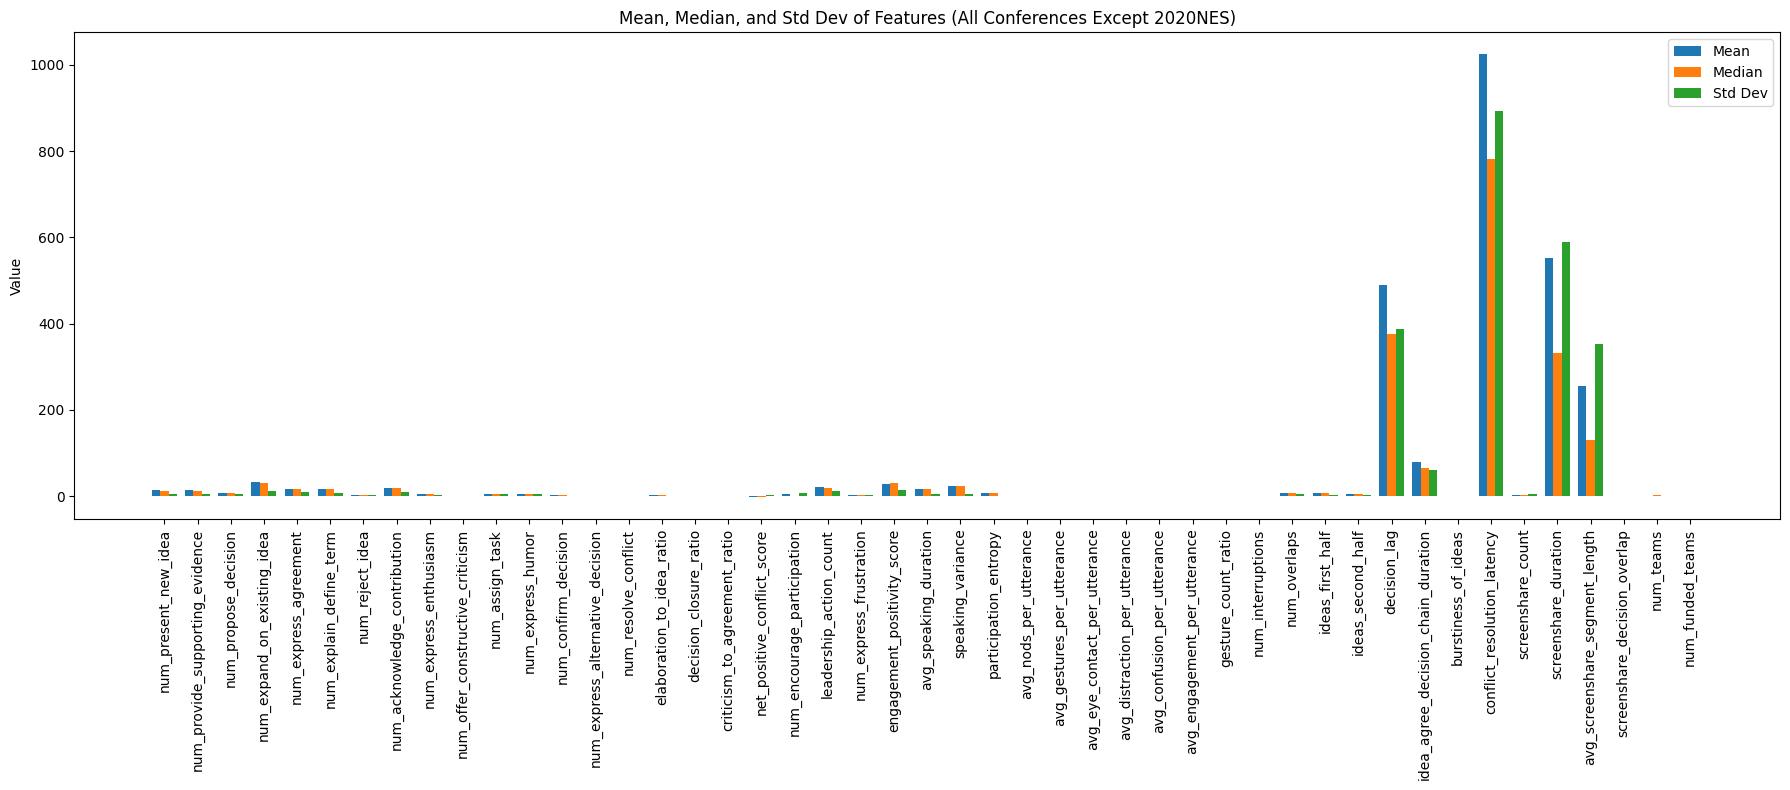

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Filter out rows where conference == '2020NES'
filtered_df = all_data_df[all_data_df['conference'] != '2020NES']

# Exclude non-numeric columns except 'conference'
numeric_cols = filtered_df.select_dtypes(include=[np.number]).columns.tolist()

# Calculate mean, median, std for each column (across all data)
mean_vals = filtered_df[numeric_cols].mean()
median_vals = filtered_df[numeric_cols].median()
std_vals = filtered_df[numeric_cols].std()

# Plotting
x = np.arange(len(numeric_cols))
width = 0.25

fig, ax = plt.subplots(figsize=(18, 8))
ax.bar(x - width, mean_vals, width, label='Mean')
ax.bar(x, median_vals, width, label='Median')
ax.bar(x + width, std_vals, width, label='Std Dev')

ax.set_xticks(x)
ax.set_xticklabels(numeric_cols, rotation=90)
ax.set_ylabel('Value')
ax.set_title('Mean, Median, and Std Dev of Features (All Conferences Except 2020NES)')
ax.legend()
plt.tight_layout()
plt.show()
